In [1]:
!pip install statsmodels
!pip install pmdarima

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from datetime import timedelta
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

base_dir = '/content/drive/MyDrive/'

# Checking the Data

First thing to do is loading the data and checking what the structure is like.

In [3]:
data_file = base_dir + 'Datos_Prueba_DataScientist.csv'
raw_df = pd.read_csv(data_file)
raw_df.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153275 entries, 0 to 153274
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OrderId         153275 non-null  object
 1   RequestTime     153275 non-null  object
 2   DeliveryOption  153275 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB


We can see that the DeliveryOption is a string, since it's hard to know by eye whether all strings referring to the same delivery option are written in the same way we do a fast check of how many different values the column has

In [5]:
raw_df.DeliveryOption.unique()

array(['Mismo dia entre 6:30 pm y 8:30 pm',
       'Siguiente dia entre 12:30 pm y 2:30 pm',
       'Siguiente dia entre las 6:30 pm y 8:30 pm'], dtype=object)

There are only 3 different values, which is good because this was expected. We could modify this column to be a categorical column and map those strings to codes, but to avoid modifying the original data we'll create a new column for that with shorter names.

In [6]:
raw_df['delivery_code'] = 'None'
raw_df.delivery_code[raw_df.DeliveryOption == 'Mismo dia entre 6:30 pm y 8:30 pm'] = 'SAME_DAY'
raw_df.delivery_code[raw_df.DeliveryOption == 'Siguiente dia entre 12:30 pm y 2:30 pm'] = 'NEXT_DAY_AFTERNOON'
raw_df.delivery_code[raw_df.DeliveryOption == 'Siguiente dia entre las 6:30 pm y 8:30 pm'] = 'NEXT_DAY_EVENING'
raw_df.delivery_code = pd.Categorical(raw_df.delivery_code, categories=['SAME_DAY', 'NEXT_DAY_AFTERNOON', 'NEXT_DAY_EVENING'])
raw_df.head()

,OrderId,RequestTime,DeliveryOption,delivery_code
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON


In [7]:
raw_df.delivery_code.cat.categories

Index(['SAME_DAY', 'NEXT_DAY_AFTERNOON', 'NEXT_DAY_EVENING'], dtype='object')

Since same day orders have a precondition (they have to be placed before 12:00:00) we'll check that all same day orders are valid. Lexicographic order is leveraged here to avoid parsing the date strings into date objects

In [8]:
order_times = raw_df[raw_df.delivery_code == 'SAME_DAY'].RequestTime.apply(lambda datetime: datetime[11:])
sum(order_times > '12:00:00')

0

By adding up the boolean array of orders with times greater than 12:00:00 we can check how many orders do not meet the time restriction. Since the result is 0 it means that all same day orders meet the requirement.

Now we have to identify in which day the orders would be delivered and to which shift (morning, afternoon) they would be assigned to.

In [9]:
raw_df['received_day'] = pd.to_datetime(raw_df.RequestTime, format="%Y-%m-%d")
raw_df.received_day = raw_df.received_day.dt.date
raw_df.head()

,OrderId,RequestTime,DeliveryOption,delivery_code,received_day
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01


In [10]:
raw_df['morning_shift'] = False
raw_df['delivery_date'] = raw_df.received_day

raw_df.loc[raw_df.delivery_code != 'SAME_DAY', 'morning_shift'] = True
next_day = raw_df.delivery_date[raw_df.delivery_code != 'SAME_DAY'] + timedelta(days=1)
raw_df.loc[raw_df.delivery_code != 'SAME_DAY', 'delivery_date'] = next_day 

raw_df['delivery_month'] = raw_df.delivery_date.astype(str).str[:7]
raw_df

,OrderId,RequestTime,DeliveryOption,delivery_code,received_day,morning_shift,delivery_date,delivery_month
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01,True,2018-01-02,2018-01
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01,True,2018-01-02,2018-01
...,...,...,...,...,...,...,...,...
153270,PED_153271,2021-02-28 17:19:26,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2021-02-28,True,2021-03-01,2021-03
153271,PED_153272,2021-02-28 17:19:37,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2021-02-28,True,2021-03-01,2021-03
153272,PED_153273,2021-02-28 17:43:56,Siguiente dia entre las 6:30 pm y 8:30 pm,NEXT_DAY_EVENING,2021-02-28,True,2021-03-01,2021-03
153273,PED_153274,2021-02-28 17:53:28,Siguiente dia entre las 6:30 pm y 8:30 pm,NEXT_DAY_EVENING,2021-02-28,True,2021-03-01,2021-03


The only missing piece of information is the pandemic affectedness level, which is added below

In [11]:
affectedness_level_dict = {
    "2020-03": 3,
    "2020-04": 3,
    "2020-05": 1,
    "2020-06": 1,
    "2020-07": 1,
    "2020-08": 2,
    "2020-09": 2,
    "2020-10": 1,
    "2020-11": 1,
    "2020-12": 2,
    "2021-01": 2,
    "2021-02": 1
}

affectedness_level = raw_df.delivery_month.apply(lambda item: affectedness_level_dict.get(item, 0))
raw_df['affectedness_level'] = affectedness_level
raw_df.head()

,OrderId,RequestTime,DeliveryOption,delivery_code,received_day,morning_shift,delivery_date,delivery_month,affectedness_level
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01,0
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01,0
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,SAME_DAY,2018-01-01,False,2018-01-01,2018-01,0
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01,True,2018-01-02,2018-01,0
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,NEXT_DAY_AFTERNOON,2018-01-01,True,2018-01-02,2018-01,0


With all that we now have all the data we might need

In [12]:
parsed_df = raw_df[['delivery_date', 'delivery_month', 'morning_shift', 'affectedness_level']]
parsed_df.head()

,delivery_date,delivery_month,morning_shift,affectedness_level
0,2018-01-01,2018-01,False,0
1,2018-01-01,2018-01,False,0
2,2018-01-01,2018-01,False,0
3,2018-01-02,2018-01,True,0
4,2018-01-02,2018-01,True,0


# Counting Orders

We have every order as a single row in the dataframe. To check whats the behaviour of the data and if it follows any kind of pattern we first have to count the orders

In [13]:
monthly_orders = parsed_df[['delivery_month', 'morning_shift', 'delivery_date']].groupby(['delivery_month', 'morning_shift']).agg('count')
monthly_orders.reset_index(inplace=True)
monthly_orders = monthly_orders.rename(columns={'delivery_date': 'orders'})
monthly_orders

,delivery_month,morning_shift,orders
0,2018-01,False,376
1,2018-01,True,438
2,2018-02,False,363
3,2018-02,True,371
4,2018-03,False,500
...,...,...,...
72,2021-01,False,4427
73,2021-01,True,3154
74,2021-02,False,3424
75,2021-02,True,2611


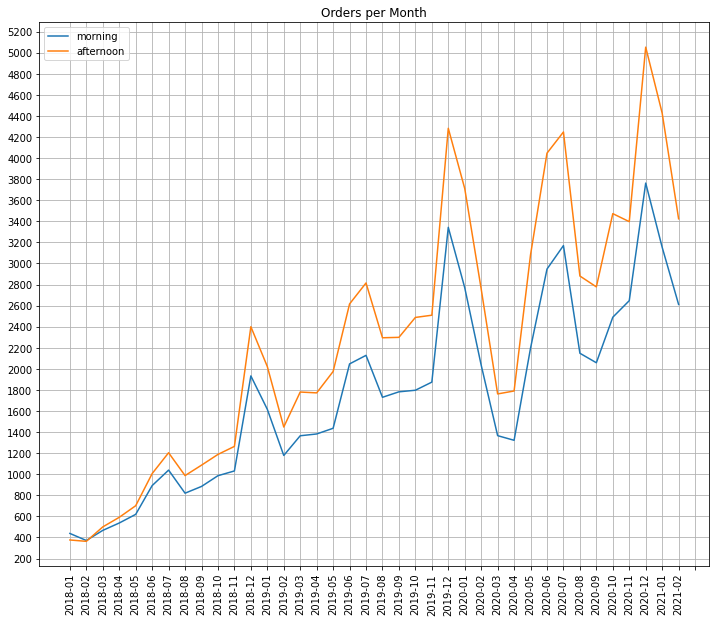

In [81]:
morning_orders = monthly_orders[monthly_orders.morning_shift == True][:-1]
afternoon_orders = monthly_orders[monthly_orders.morning_shift == False]
total_months = len(morning_orders)

plt.figure(figsize=(12,10))

plt.plot(morning_orders.delivery_month, morning_orders.orders, label='morning')
plt.plot(afternoon_orders.delivery_month, afternoon_orders.orders, label='afternoon')
plt.title("Orders per Month")
plt.xticks(range(0, total_months+1, total_months//20), rotation='vertical')
plt.yticks(range(200, 5300, 200))
plt.legend()
plt.grid()
plt.plot()
plt.show()

From the previous figure it seems that the order data is seasonal but also trendy (the last data point corresponding to march 2021 is ignored beucase theres only order data for 1 day). The data has seasonality because there are clear peaks around july and december, which most likely is related to the holidays and the mid-year bonus; and the data is trendy because it has a trend of increasing orders regardless of the peaks we see.

We'll have to deal with the data being not stationary somehow, either by using a model that considers that or by adding extra features and transforming the data

# Regression

With our data in place, and separated into morning and afternoon shifts we can now attempt to forecast what the sales for march 2021 will be.

One issue that we face is that we must always split our dataset and perform cross-validation, but since our data is not stationary it can be hard to find a good train-test split. We'll use the arima model and leverage a tool called autoarima to search for the best parameters; the train/test split was done manually leaving at most 12 months of data for testing and at minimum 3, it was not included in the notebook to avoid cluttering everything. The best split was to leave 4 months for testing and the rest for training.

In [107]:
stepwise_fit = auto_arima(afternoon_orders.orders[:-4], start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = False,
                          error_action ='ignore')
  
print(stepwise_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   34
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -162.379
Date:                             Fri, 04 Jun 2021   AIC                            330.758
Time:                                     00:41:24   BIC                            334.031
Sample:                                          0   HQIC                           331.529
                                              - 34                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1172.0180    191.861      6.109      0.000     795.977    1548.059
ma.L1          0.7219      

In [108]:
model = SARIMAX(afternoon_orders.orders.values[:-4], 
                order = (0, 1, 0), 
                seasonal_order =(0, 1, [], 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -160.256
Date:                            Fri, 04 Jun 2021   AIC                            322.513
Time:                                    00:41:27   BIC                            323.557
Sample:                                         0   HQIC                           322.740
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.487e+05   6.09e+04      4.082      0.000    1.29e+05    3.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.52   Prob(JB):                         0.47
Heteroskedasticity (H):               3.96   Skew:                            -0.37
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
x_months = list(afternoon_orders.delivery_month.values)
x_months.append('2021-03')

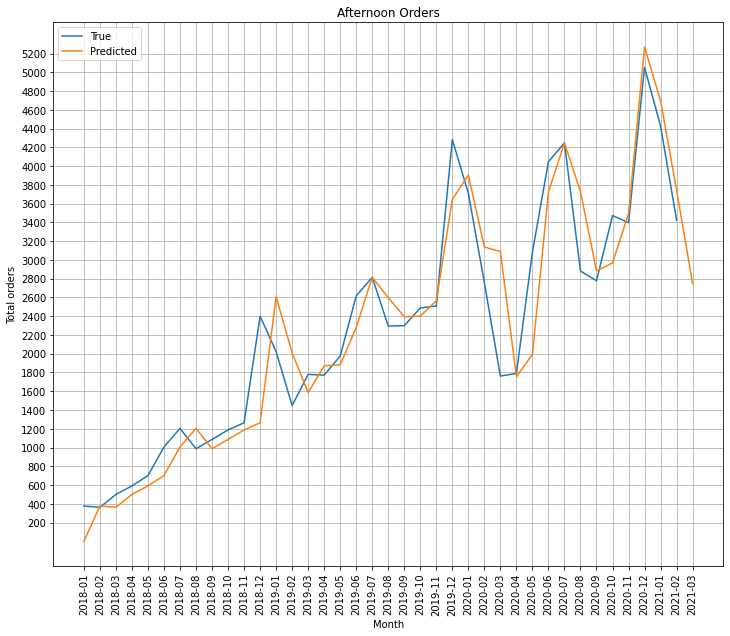

In [124]:
afternoon_preds = result.predict(0, 38)

plt.figure(figsize=(12,10))


plt.plot(afternoon_orders.orders.values, label='True')
plt.plot(afternoon_preds, label='Predicted')
len(afternoon_orders.orders)
plt.xticks(range(0, 39))
plt.title("Afternoon Orders")
plt.legend()
plt.xticks(range(0, total_months+1, total_months//20), x_months, rotation='vertical')
plt.yticks(range(200, 5300, 200))
plt.xlabel('Month')
plt.ylabel('Total orders')
plt.grid()
plt.show()

The predictions are very similar to the real thing, we repeat the same process but for the afternoon shift.

In [125]:
stepwise_fit = auto_arima(morning_orders.orders[:-4], start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = False,
                          error_action ='ignore')
  
print(stepwise_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   34
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -155.819
Date:                             Fri, 04 Jun 2021   AIC                            317.637
Time:                                     00:56:40   BIC                            320.910
Sample:                                          0   HQIC                           318.408
                                              - 34                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    809.7306    133.119      6.083      0.000     548.822    1070.639
ma.L1          0.7461      

In [126]:
model = SARIMAX(morning_orders.orders.values[:-4], 
                order = (0, 1, 0), 
                seasonal_order =(0, 1, [], 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -153.770
Date:                            Fri, 04 Jun 2021   AIC                            309.539
Time:                                    00:56:45   BIC                            310.584
Sample:                                         0   HQIC                           309.766
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.34e+05    3.7e+04      3.626      0.000    6.16e+04    2.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.71   Prob(JB):                         0.88
Heteroskedasticity (H):               4.33   Skew:                             0.07
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

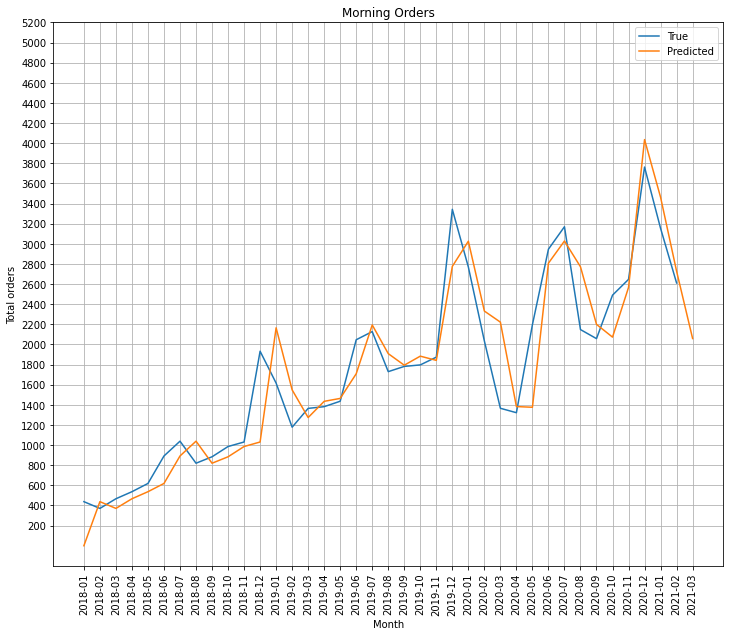

In [127]:
morning_preds = result.predict(0, 38)

plt.figure(figsize=(12,10))


plt.plot(morning_orders.orders.values, label='True')
plt.plot(morning_preds, label='Predicted')
plt.xticks(range(0, 39))
plt.title("Morning Orders")
plt.legend()
plt.xticks(range(0, total_months+1, total_months//20), x_months, rotation='vertical')
plt.yticks(range(200, 5300, 200))
plt.xlabel('Month')
plt.ylabel('Total orders')
plt.grid()
plt.show()

With both shifts in place, the total number of workers for each can now be calculated

In [134]:
pred_march_morning_orders = morning_preds[-1]
pred_march_afternoon_orders = afternoon_preds[-1]
hours_per_shift = 6
orders_per_hour = 5
orders_per_worker = orders_per_hour * hours_per_shift
print("Expected orders for the morning shift: ", pred_march_morning_orders)
print("Expected orders for the afternoon shift: ", pred_march_afternoon_orders)
print("Max orders a worker can take: ", orders_per_worker)
mm_workers = math.ceil(pred_march_morning_orders / orders_per_worker)
print("March morning shift workers: ", mm_workers)
ma_workers = math.ceil(pred_march_afternoon_orders / orders_per_worker)
print("March morning shift workers: ", ma_workers)

Expected orders for the morning shift:  2059.0
Expected orders for the afternoon shift:  2747.0
Max orders a worker can take:  30
March morning shift workers:  69
March morning shift workers:  92


# What to do Next

In the end we got predictions that seemed very close to the actual number of orders, and we got a forecast of 69 workers for the morning shift and 92 for the afternoon one. 
The fact that the predictions are so close to the real thing could mean that we've got a case of overfitting in the model; we could try to check if that's the case by analysing data in a smaller scale, maybe bi-weekly or weekly instead of monthly. That comes with problems of its own since because single days are way more sensitive to external factors (like holidays or weekends) and the closer we get to that scale the more of that noise we'll have in our data.

One last problem that was noticed right at the end of the analysis was that the pandemic affectedness level was completely disregarded for the predictions. To be honest this was an accident as I didn't realise until it was too late. With more time it would be work checking how this extra feature would affect the predictions. Most likely different models would have to be tested to support this additional feature, so a way of keeping the context/data of previous days for the current data would need to be added as well. This could be in the form of adding previous data as new features, for example 12 new features each one indicating the number of orders for the previous 12 months.